(ABC_introduction)=
# Approximate Bayesian Computation
:::{post} May 31, 2022
:tags: SMC, ABC 
:category: beginner, explanation
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.1


In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")

# Sequential Monte Carlo - Approximate Bayesian Computation

Approximate Bayesian Computation methods (also called likelihood free inference methods), are a group of techniques developed for inferring posterior distributions in cases where the likelihood function is intractable or costly to evaluate. This does not mean that the likelihood function is not part of the analysis, it just the we are approximating the likelihood, and hence the name of the ABC methods.

ABC comes useful when modeling complex phenomena in certain fields of study, like systems biology. Such models often contain unobservable random quantities, which make the likelihood function hard to specify, but data can be simulated from the model.  

These methods follow a general form:

1- Sample a parameter $\theta^*$ from a prior/proposal distribution $\pi(\theta)$.

2- Simulate a data set $y^*$ using a function that takes $\theta$ and returns a data set of the same dimensions as the observed data set $y_0$ (simulator).

3- Compare the simulated dataset $y^*$ with the experimental data set $y_0$ using a distance function $d$ and a tolerance threshold $\epsilon$. 

In some cases a distance function is computed between two summary statistics $d(S(y_0), S(y^*))$, avoiding the issue of computing distances for entire datasets.

As a result we obtain a sample of parameters from a distribution $\pi(\theta | d(y_0, y^*)) \leqslant \epsilon$. 

If $\epsilon$ is sufficiently small this distribution will be a good approximation of the posterior distribution $\pi(\theta | y_0)$.

[Sequential monte carlo](https://docs.pymc.io/notebooks/SMC2_gaussians.html?highlight=smc) ABC is a method that iteratively morphs the prior into a posterior by propagating the sampled parameters through a series of proposal distributions $\phi(\theta^{(i)})$, weighting the accepted parameters $\theta^{(i)}$ like:

$$ w^{(i)} \propto \frac{\pi(\theta^{(i)})}{\phi(\theta^{(i)})} $$

It combines the advantages of traditional SMC, i.e. ability to sample from distributions with multiple peaks, but without the need for evaluating the likelihood function. 


_(Lintusaari, 2016), (Toni, T., 2008), (Nuñez, Prangle, 2015)_

# Old good Gaussian fit

To illustrate how to use ABC within PyMC3 we are going to start with a very simple example estimating the mean and standard deviation of Gaussian data.

In [3]:
data = np.random.normal(loc=0, scale=1, size=1000)

Clearly under normal circumstances using a Gaussian likelihood will do the job very well. But that would defeat the purpose of this example, the notebook would end here and everything would be very boring. So, instead of that we are going to define a simulator. A very straightforward simulator for normal data is a pseudo random number generator, in real life our simulator will be most likely something fancier.

In [4]:
def normal_sim(rng, a, b, size=1000):
    return rng.normal(a, b, size=size)

Defining an ABC model in PyMC3 is in general, very similar to defining other PyMC3 models. The two important differences are: we need to define a `Simulator` _distribution_ and we need to use `sample_smc` with `kernel="ABC"`. The `Simulator` works as a generic interface to pass the synthetic data generating function (_normal_sim_ in this example), its parameters, the observed data and optionally a distance function and a summary statistics. In the following code we are using the default distance, `gaussian_kernel`, and the `sort` summary_statistic. As the name suggests `sort` sorts the data before computing the distance.

Finally, SMC-ABC offers the option to store the simulated data. This can he handy as simulators can be expensive to evaluate and we may want to use the simulated data for example for posterior predictive checks.

In [5]:
with pm.Model() as example:
    a = pm.Normal("a", mu=0, sigma=5)
    b = pm.HalfNormal("b", sigma=1)
    s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="sort", epsilon=1, observed=data)

    idata = pm.sample_smc()
    idata.extend(pm.sample_posterior_predictive(idata))

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


Sampling: [s]


Judging by `plot_trace` the sampler did its job very well, which is not surprising given this is a very simple model. Anyway, it is always reassuring to look at a flat rank plot :-)

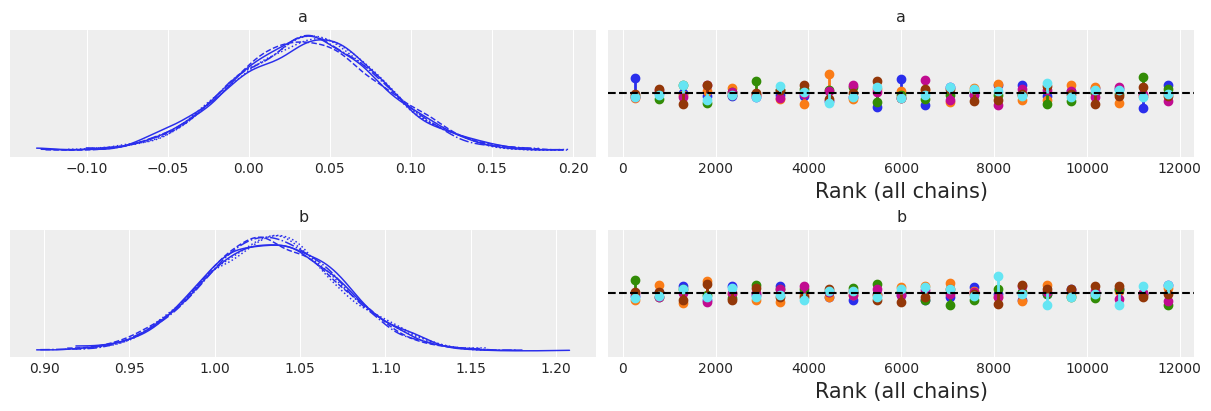

In [6]:
az.plot_trace(idata, kind="rank_vlines");

In [7]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,0.037,0.045,-0.046,0.124
b,1.034,0.039,0.960,1.108


The posterior predictive check shows that we have an overall good fit, but the synthetic data has heavier tails than the observed one. You may want to decrease the value of epsilon, and see if you can get a tighter fit.

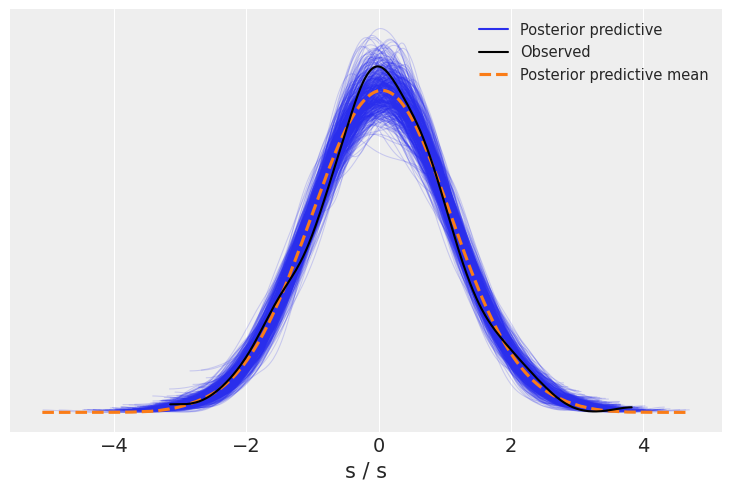

In [8]:
az.plot_ppc(idata, num_pp_samples=500);

## Lotka–Volterra

The Lotka-Volterra is well-know biological model describing how the number of individuals of two species change when there is a predator/prey interaction (A Biologist’s Guide to Mathematical Modeling in Ecology and Evolution,Otto and Day, 2007). For example, rabbits and foxes. Given an initial population number for each species, the integration of this ordinary differential equations (ODE) describes curves for the progression of both populations. This ODE's takes four parameters:

* a is the natural growing rate of rabbits, when there's no fox.
* b is the natural dying rate of rabbits, due to predation.
* c is the natural dying rate of fox, when there is no rabbit.
* d is the factor describing how many caught rabbits let create a new fox.

Notice that there is nothing intrinsically especial about SMC-ABC and ODEs. In principle a simulator can be any piece of code able to generate fake data given a set of parameters.

In [9]:
from scipy.integrate import odeint

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)


# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """Return the growth rate of fox and rabbit populations."""

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])


# simulator function
def competition_model(rng, a, b, size=None):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

Using the simulator function we will obtain a dataset with some noise added, for using it as observed data.

In [10]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(None, a, b) + noise
    return simulated

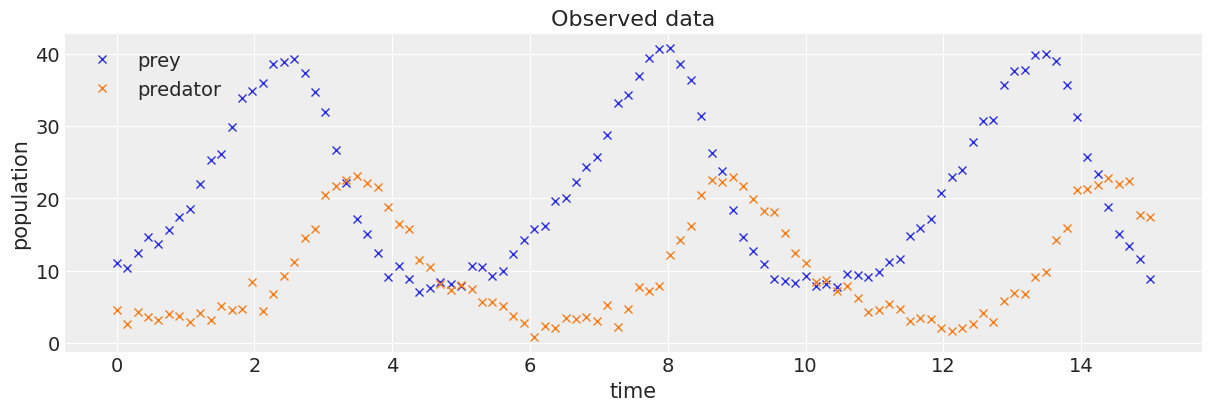

In [11]:
# plotting observed data.
observed = add_noise(a, b)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, observed[:, 0], "x", label="prey")
ax.plot(t, observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

As with the first example, instead of specifying a likelihood function, we use `pm.Simulator()`.

In [12]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0)
    b = pm.HalfNormal("b", 1.0)

    sim = pm.Simulator("sim", competition_model, params=(a, b), epsilon=10, observed=observed)

    idata_lv = pm.sample_smc()

Initializing SMC sampler...
Sampling 6 chains in 6 jobs


/tmp/ipykernel_1430735/1881729530.py:22: RuntimeWarning: overflow encountered in multiply
  return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])
/home/dylan/.local/share/virtualenvs/project1-N1VmeQ3a/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1363636363636D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.1352093841585D+02   r2 =  0.1354476646447D+02
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1378787878788D+02
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.1352093841585D+02   r2 =  0.1354476646447D+02
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.1378787878788D+02


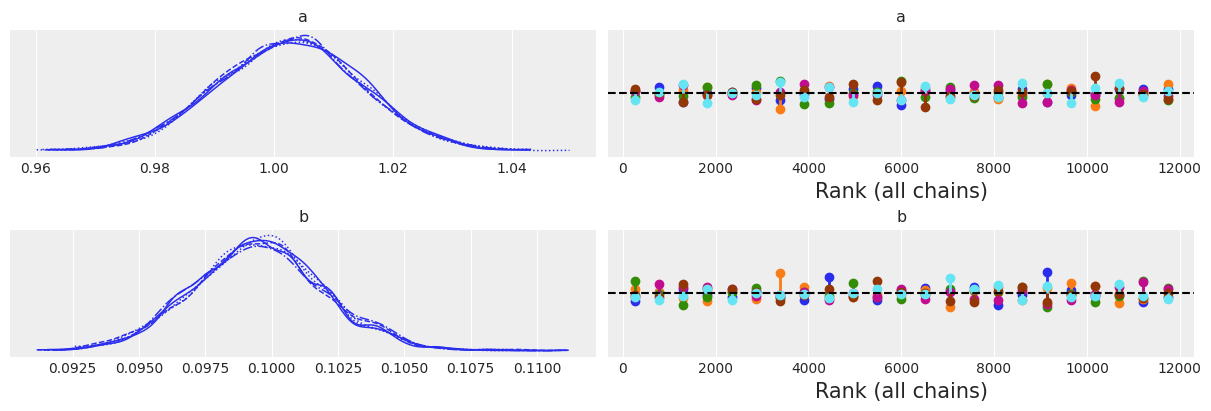

In [13]:
az.plot_trace(idata_lv, kind="rank_vlines");

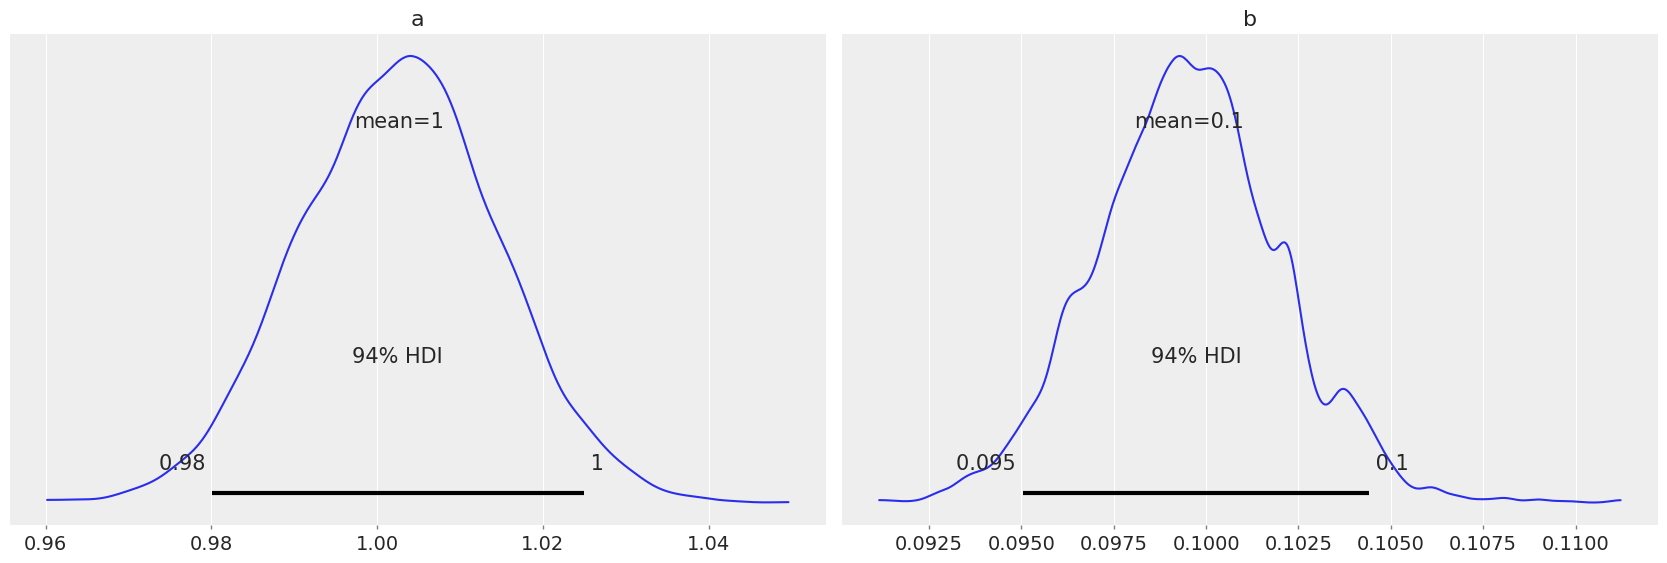

In [14]:
az.plot_posterior(idata_lv);

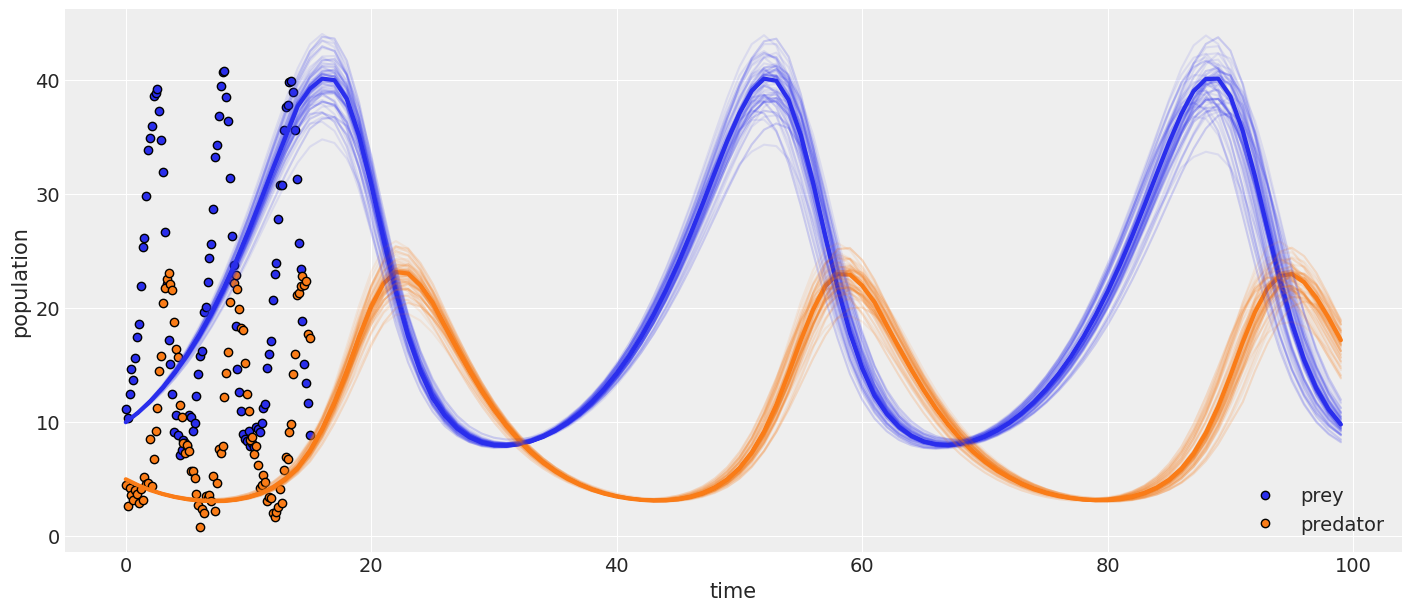

In [15]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(t, observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(t, observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(None, posterior["a"].mean(), posterior["b"].mean()), linewidth=3)
for i in np.random.randint(0, size, 75):
    sim = competition_model(None, posterior["a"][i], posterior["b"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

## References

:::{bibliography}
:filter: docname in docnames

martin2021bayesian
:::

In [16]:
%watermark -n -u -v -iv -w

Last updated: Thu Nov 16 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.17.1

pymc      : 5.9.1
numpy     : 1.25.2
arviz     : 0.16.1
matplotlib: 3.8.0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::